In [1]:
import numpy as np
import matplotlib.pyplot as plt, matplotlib.font_manager as fm, os
from mpl_toolkits.mplot3d.axes3d import Axes3D
from scipy.integrate import odeint
from sklearn.preprocessing import StandardScaler
import pandas as pd

## Il dataset artificiale generato con il sistema di Lorenz
>Il sistema di Lorenz è il primo esempio di un sistema di equazioni differenziali a bassa dimensionalità in grado di generare un comportamento caotico nel movimento termico di convezione di un fluido. Venne scoperto da Edward N. Lorenz, del Massachusetts Institute of Technology, nel 1963. Il sistema è composto dalle seguenti equazioni differenziali:

$$
\dot{z}_1(t)=\sigma(z_2(t)-z_1(t)) \\
\dot{z}_2(t)=z_1(t)(\rho-z_3(t))-z_2(t)\\
\dot{z}_3(t)=z_1(t)z_2(t)-\beta z_3(t)
$$

>Il sistema dipende da tre parametri $\sigma$, $\rho$ e $\beta$ che rappresentano rispettivamente il numero di Prandtl,  il numero di Rayleigh ed una costantante posta a 8/3. Seguendo ciò che è riportato in [1] si settano i parametri nel seguente modo: 

In [2]:
np.random.seed(42)
sigma = 10.     
rho   = 28.
beta  = 8./3.

La funzione Python che definisce il sistema di Lorenz è la seguente:

In [3]:
def lorenz_system(current_state, t):
    
    # positions of x, y, z in space at the current time point
    x, y, z = current_state
    
    # define the 3 ordinary differential equations known as the lorenz equations
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    
    # return a list of the equations that describe the system
    return [dx_dt, dy_dt, dz_dt]

> Vogliamo generare un dataset di 1000 esempi in 3 dimensione, per t che va da 0s a 1000s

In [4]:
# define the time points to solve for, evenly spaced between the start and end times
start_time = 0
end_time = 1000
time_points = np.arange(start_time, end_time)


In [5]:
initial_state = [0.1, 0., 0.] #che fa questo?
lorenz_system = odeint(lorenz_system, initial_state, time_points)

# extract the individual arrays of x, y, and z values from the array of arrays
x = lorenz_system [:, 0]
y = lorenz_system [:, 1]
z = lorenz_system [:, 2]


> Salviamo i dati generati sul csv lorenz_system.csv

In [6]:
from path import Path # gestione dei path per l'import

In [7]:
PROJ_DIR = Path().getcwd().parent
DATA_DIR = PROJ_DIR / "data"
print(DATA_DIR)
lorenz_data = pd.DataFrame(data=lorenz_system, columns=['x', 'y', 'z'])
lorenz_data.to_csv(DATA_DIR /'lorenz_system.csv', index=False)

/home/ec2-user/SageMaker/MASL_project_2019/data


In [8]:
DATA_DIR /'lorenz_system.csv'

Path('/home/ec2-user/SageMaker/MASL_project_2019/data/lorenz_system.csv')

## Generazione delle anomalie nel dataset
> Per creare i dati anomali, gli autori dell'articolo modificano le componenti z dei punti generati dal secondo 850 al secondo 1000 cambiando l'ordine cronologico della componente z.

In [9]:
z[850:]=np.flip(z[850:])
lorenz_system[:, 2]=z

In [10]:
label = np.zeros(1000, dtype='int').reshape(1000,1)

In [11]:
for i in np.arange(850,1000):
    label[i] = 1

>Adesso eseguiamo uno scatterplot in 3D per visualizzare, in blu i dati normali e in rosso i dati anomali

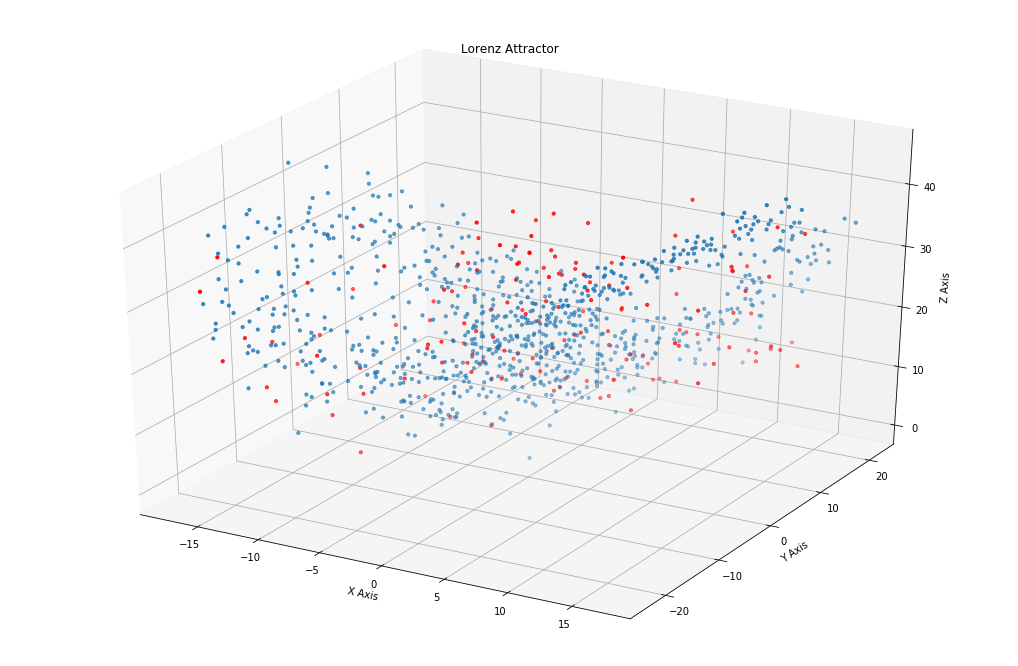

In [12]:
# Plot
fig = plt.figure(figsize=(18,12))
#fig = plt.figure()
zx = fig.gca(projection='3d')
zx.scatter3D(x[850:1000], y[850:1000], z[850:1000],s=10,c="red")
zx.scatter3D(x[0:849], y[0:849], z[0:849],s=10)
zx.set_xlabel("X Axis")
zx.set_ylabel("Y Axis")
zx.set_zlabel("Z Axis")
zx.set_title("Lorenz Attractor")
plt.show()

>La generazione di un vettore ad alta dimensionalità viene eseguita nel seguente modo. Sia $W\in\mathbb{R}^{25\times3}$ una matrice contenente numeri casuali scelti nell'intervallo (-5,5) e sia $Z=\{z(t)\}_{t \in [1,1000]}$ il vettore contenente tutti i punti tridimensionali generati dal sistema di Lorenz (quindi $Z\in\mathbb{R}^{3\times1000}$), allora la matrice $X=W*Z\in\mathbb{R}^{25\times1000}$ è un vettore ad alta dimensionalità.   

In [13]:
W=np.random.rand(25,3)
W*=10
W-=5
X=np.dot(W,np.transpose(lorenz_system))
X.shape

(25, 1000)

>Si standardizza il dataset temporale ottenuto per righe 

In [14]:
SC = StandardScaler()
lorenz_std = np.transpose(SC.fit_transform(np.transpose(X)))
print(lorenz_std.shape)# fai standardizz per colonne

(25, 1000)


>Visualizzo l'andamento temporale:

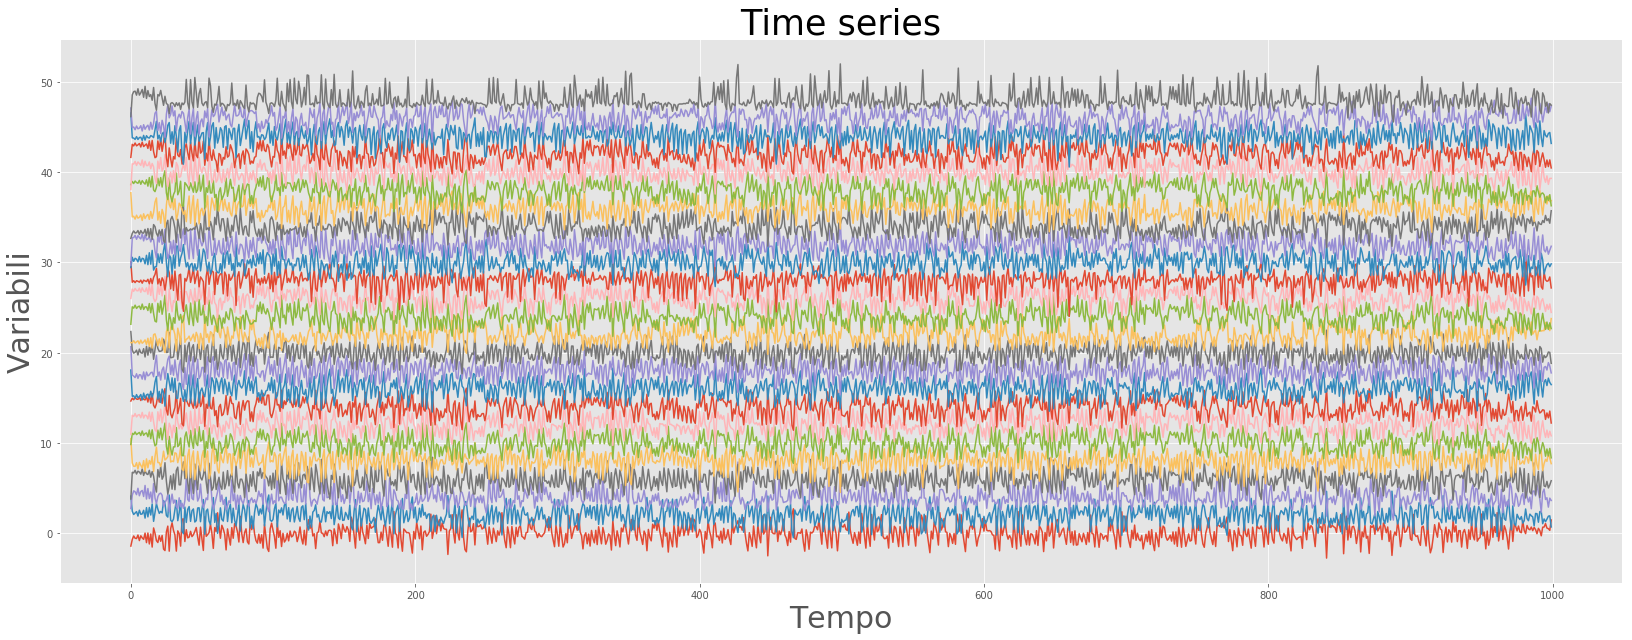

In [15]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.title("Time series", size=35)
    plt.xlabel("Tempo", size=30)
    plt.ylabel("Variabili", size = 30)
    for i in np.arange(0,25):
        plt.plot(time_points, lorenz_std[i,:]+i*2)
    

In [16]:
lorenz_std_DF = pd.DataFrame(lorenz_std).T #trasponi la standd
#lorenz_std_DF = pd.DataFrame(data=lorenz_std_DF)
lorenz_std_DF['label'] = label
lorenz_std_DF = lorenz_std_DF.to_csv(DATA_DIR /'lorenz_system_std.csv', index=False)

## Riferimenti

[1] M. Sakurada and T. Yairi, *Anomaly Detection Using Autoencoders with Nonlinear Dimensionality Reduction*, 2014 ACM